## Modules

In [1]:
# Modules
import sys
sys.path.append("/home/simon/Documents/REPO/Exact_laws")
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_exactlaw/notebook")

from exact_laws.preprocessing.process_on_standard_h5_file import describ_file
from visualisation_tools import *
from exact_laws.mathematical_tools.derivation import cdiff

import os
from matplotlib import ticker, rc
import numpy as np
import json

In [2]:
# Matplotlib config
%matplotlib widget
#%matplotlib qt5
plt.rcParams['text.usetex'] = True
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('font', size=18)

numfig = 0

## Informations et données

In [3]:
simu_name = 'CGL1'
with open("/home/simon/Documents/REPO/Simu/descript_oca_simu.json","r") as f:
    simus = json.load(f)[simu_name]
#del(simus['10600'],simus['12500'],simus['12785'],simus['12800'],simus['12815'],)
times = list(simus.keys())
for t in times : 
    if not '6700.' in t: del(simus[t])
times = list(simus.keys())
simus_name= 'CGL1.6700'
print(simus[times[0]])

{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL1/CGL1_6700f/', 'cycle': 'cycle_0', 'group_grid': '3Dgrid', 'N': [512, 512, 512], 'kdi': 0.045454545454545456, 'theta': 1.4597608823983306, 'thrsh_forc_hi': 0.016, 'thrsh_forc_lo': 0.015, 'a1_forc': 0.5, 'act_forc': True, 'nu': 7.35e-08, 'eta': 7.35e-08, 'hdiss_rho': 0, 'hdiss_p': 7.35e-09, 'an_hd': 80, 'ap0': 1, 'B0': [0, 0, 1], 'beta0': 1, 'name': 'CGL1.6700.0000', 'EL_red1D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alli_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alleq_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_allinc_EL_lincart_all_red1D.h5'], 'EL_red2D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alli_EL_lincart_all_red2D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alleq_EL_

In [5]:
# Paths 
path_record_images = f"./images_{simu_name}/"
if not os.path.exists(path_record_images) : os.mkdir(path_record_images)

In [6]:
# Paramètres
simu = f"{simu_name}"
kdi = simus[times[0]]['kdi'] # kperpdi = 2pidi/l => l/di = 2pi/(kdi)
theta = simus[times[0]]['theta']
lforc = np.array([(2*np.pi/kdi, 2*np.pi/kdi*np.tan(theta)),(2*np.pi/kdi/np.sqrt(2), 2*np.pi/kdi*np.tan(theta))]) # (lperp/di, lpar/di)
linert = (1,1)
print(lforc)

[[ 138.23007676 1239.79812481]
 [  97.74342464 1239.79812481]]


In [7]:
# Grille
grid = read_grid_in_h5file(simus[times[0]]['EL_red2D'][0])
c = grid['c']
axe_par = np.array(grid['lpar'])*grid['c'][2]
axe_perp = np.array(grid['lperp'])#*grid['c'][0]
label_par = "$\ell_{\parallel} / d_i$"
label_perp = "$\ell_{\perp}/ d_i$"
del(grid)
grid = read_grid_in_h5file(simus[times[0]]['EL_red1D'][0])
axe_l = np.array(grid['l'])
label_l = "$\ell / d_i$"
print(axe_par[1],axe_par[2],max(axe_par))
print(axe_perp[1],axe_perp[2],max(axe_perp))
print(axe_l[1],max(axe_l))

2.4214807125247577 4.842961425049515 617.4775816938132
0.2699806186678728 0.5399612373357456 68.84505776030757
0.2699806186678728 68.84505776030757


In [8]:
gridlp, gridlpar = np.meshgrid(axe_perp,axe_par, indexing='ij')
filt_45 = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))*180/np.pi
filt_45inf = np.where(filt_45<=45,1,np.nan)
filt_45sup = np.where(filt_45>=45,1,np.nan)
filt_45b = np.arctan(gridlpar/c[2]/np.where(gridlp/c[0]==0,1e-19,gridlp/c[0]))*180/np.pi
filt_45binf = np.where(filt_45b<=45,1,np.nan)
filt_45bsup = np.where(filt_45b>=45,1,np.nan)
filt_perp10pc = np.where(gridlp<=lforc[1,0]*0.1,1,np.nan)
filt_par10pc = np.where(gridlpar<=lforc[1,1]*0.1,1,np.nan)
del(gridlp,gridlpar)

In [9]:
# liste des temps
dict_temps = {}
for t in times : 
    if '_R' in t : 
        dict_temps[t] = eval(t[:-2])
    else : 
        dict_temps[t] = eval(t)
temps =  sorted(dict_temps.items(), key=lambda t: t[1])
dt = temps[1][1] - temps[0][1]

0.0625

## Lecture et assemblage de lois exactes

In [11]:
# Lecture fichiers et corrections
dict_quantities = {}
dict_quantities1D = {}
dict_coeffs = {}
quantities = {} 
quantities1D = {}  
coeffs = {}

for it,t in enumerate(simus.keys()):
    dict_quantities[t] = {}
    dict_coeffs[t] = {}
    for fstr in simus[t]['EL_red2D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities[t][k] = dqs[k] 
        for k in dcs.keys():
            dict_coeffs[t][k] = dcs[k]
            if "source_rbdd" in k:
                print(k, dict_coeffs[t][k]) 
                dict_coeffs[t][k] = -np.abs(dcs[k])
                print(k, dict_coeffs[t][k]) 
            if "ue" in k :
                print(k, dict_coeffs[t][k]) 
                dict_coeffs[t][k] = -np.abs(dcs[k])*1836
    dict_coeffs[t]['COR_dt_cor_rvv'] = 1
    dict_coeffs[t]['COR_dt_cor_rbb'] = 1
    dict_coeffs[t]['COR_dt_cor_ru'] = 1
    dict_coeffs[t]['ICOR_dt_cor_vv'] = 1
    dict_coeffs[t]['ICOR_dt_cor_bb'] = 1
    
    dict_quantities1D[t] = {}
    for fstr in simus[t]['EL_red1D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities1D[t][k] = dqs[k] 
for q in dict_quantities[times[-1]].keys():
    quantities[q] = np.mean(np.array([dict_quantities[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_quantities1D[times[-1]].keys():
    quantities1D[q] = np.mean(np.array([dict_quantities1D[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_coeffs[times[-1]].keys():
    coeffs[q] = dict_coeffs[times[-1]][q]


/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alli_EL_lincart_all_red2D.h5
/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alleq_EL_lincart_all_red2D.h5
SS21Elec_div_flux_drduedj 0.5
SS21Elec_div_flux_drduedv -0.5
SS21Elec_source_rbddpe 0.25
SS21Elec_source_rbddpe -0.25
SS21Elec_source_rduedj 0.5
SS21Elec_source_rduedv -0.5
SS22Elec_div_flux_drduedj 0.5
SS22Elec_div_flux_drduedv -0.5
SS22Elec_source_rbddpe 0.25
SS22Elec_source_rbddpe -0.25
SS22Elec_source_rduedj 0.5
SS22Elec_source_rduedv -0.5
/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_allinc_EL_lincart_all_red2D.h5
/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.1/OCA_CGL1.6700.1_alli_EL_lincart_all_red2D.h5
/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.1/OCA_CGL1.6700.1_alleq_EL_lincart_all_red2D.h5
SS21Elec_div_flux_drduedj 0.5
SS21Elec_div_flux_drduedv -0.5
SS21Elec_source_rbddpe 0.25
SS21Elec_source_rbddpe -0.25
SS21Ele

In [12]:
# dt des quantitées
quantities_name = [k for k in quantities if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    for i in range(len(temps)):
        dict_quantities[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities['dt_'+q] = np.mean(dt_tab[1:-1],axis=0)

# dt des quantitées
quantities_name = [k for k in quantities1D if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities1D[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    if q == 'cor_rvv': print(dt_tab[0][0],dt_tab[1][0],dt_tab[1][0])
    for i in range(len(temps)):
        dict_quantities1D[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities1D['dt_'+q] = np.mean(dt_tab,axis=0)

-1.2844832393998917e-05 -1.2836495683454796e-05 -1.2836495683454796e-05


In [13]:
# Combinaisons de termes
dic_of_list_terms = {}
dic_of_list_terms['PP98'] = [k for k in coeffs if k.startswith('PP98_')]

In [15]:
y1D = linear_op_from_list_term(coeffs,quantities1D,dic_of_list_terms['PP98'])
y2D = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['PP98'])

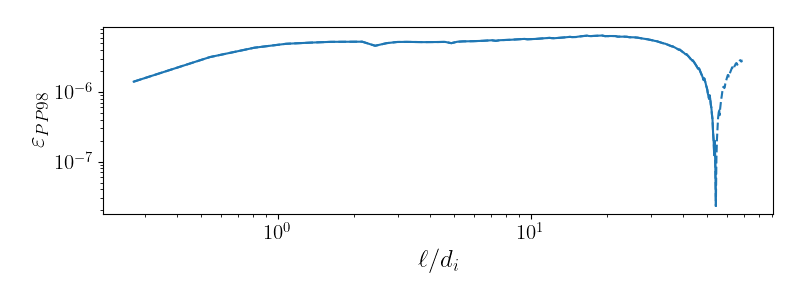

In [16]:
plt.figure('M1', figsize=(8,3))
plt.clf()
splot(axe_l[1:],y1D[1:],label = '$\\varepsilon_{PP98}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell/d_i$')
plt.tight_layout()
plt.show()

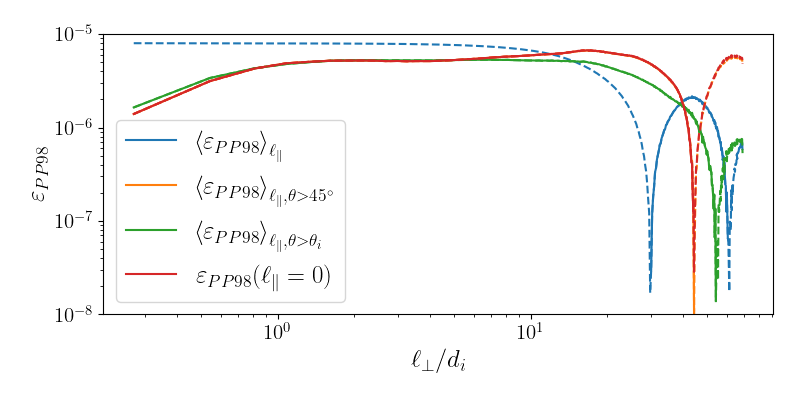

In [36]:
plt.figure('M2', figsize=(8,4))
plt.clf()
splot(axe_perp[1:],np.nanmean(y2D,axis=1)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\parallel}} $') 
splot(axe_perp[1:],np.nanmean(y2D*filt_45inf,axis=1)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\parallel}, \\theta > 45^{\circ} }$')
splot(axe_perp[1:],np.nanmean(y2D*filt_45binf,axis=1)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\parallel}, \\theta > \\theta_i }$')  
splot(axe_perp[1:],y2D[1:,0],label = '$\\varepsilon_{PP98}(\ell_{\\parallel} = 0)$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-5)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_15952/2748838596.py:4: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y2D*filt_45sup,axis=0)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\perp}, \\theta < 45^{\circ} }$')
/tmp/ipykernel_15952/2748838596.py:5: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y2D*filt_45bsup,axis=0)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\perp}, \\theta < \\theta_i }$')


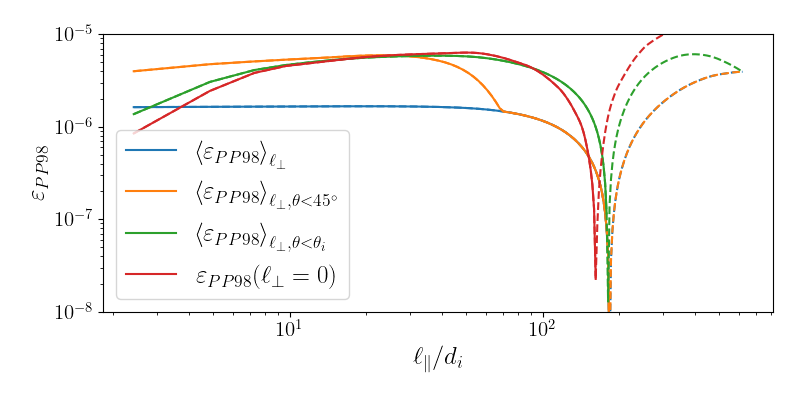

In [39]:
plt.figure('M3', figsize=(8,4))
plt.clf()
splot(axe_par[1:],np.nanmean(y2D,axis=0)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\perp}} $') 
splot(axe_par[1:],np.nanmean(y2D*filt_45sup,axis=0)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\perp}, \\theta < 45^{\circ} }$')
splot(axe_par[1:],np.nanmean(y2D*filt_45bsup,axis=0)[1:],label = '$\\left<\\varepsilon_{PP98}\\right>_{\ell_{\\perp}, \\theta < \\theta_i }$')  
splot(axe_par[1:],y2D[0,1:],label = '$\\varepsilon_{PP98}(\ell_{\\perp} = 0)$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-5)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\parallel}/d_i$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

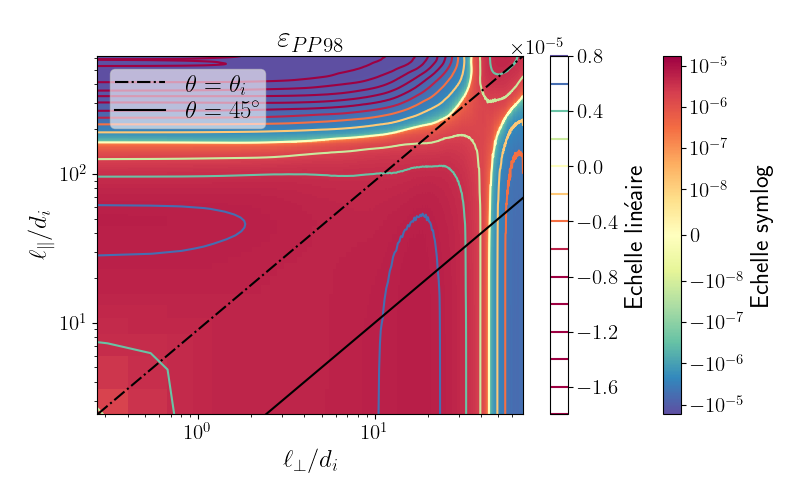

In [34]:
X,Y = np.meshgrid(axe_perp,axe_par)
plt.figure('M4', figsize=(8,5))
plt.clf()
plt.title('$\\varepsilon_{PP98}$')
colormap = plt.pcolor(X,Y,np.transpose(y2D), norm=colors.SymLogNorm(linthresh = 1e-8, vmin = - np.max(np.abs(y2D)), vmax=np.max(np.abs(y2D))),
                   cmap='Spectral_r', shading='auto')
plt.colorbar(colormap,label='Echelle symlog')
contours = plt.contour(X,Y,np.transpose(y2D),15,cmap='Spectral',vmin = - np.max(y2D), vmax=np.max(y2D))
#plt.clabel(contours, inline=False, fontsize=15,rightside_up=True,use_clabeltext =True,
           #manual=[(1,413),(1,320),(1,240),(1,167),(1,67),(0.5,12)])#fmt='%.1E',inline_spacing=1,
plt.colorbar(contours,label='Echelle linéaire')
plt.plot(axe_perp[1:],axe_perp[1:]*np.tan(theta),'k-.',label='$\\theta = \\theta_i$')
plt.plot(np.array([1,10,100,1000]),np.array([1,10,100,1000]),'k',label='$\\theta = 45^{\circ}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.ylim(axe_par[1],axe_par[-1])
plt.ylabel('$\ell_{\\parallel}/d_i$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(framealpha=0.6,labelspacing=0.2,borderpad=0.2)
plt.tight_layout()
plt.show()